### **Import the necessary libraries**

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### **Import Dataset & Overview**

In [69]:
df = pd.read_csv("https://raw.githubusercontent.com/Alfredo2212/credit_risk-240625/main/data/credit_risk.csv")

In [70]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [71]:
df.shape

(5960, 13)

### **Data Wrangling PRE Tableau**

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


The credit risk dataset consists of 5,960 records across 13 variables, with the target variable BAD indicating loan default. While key variables like LOAN and BAD are complete, many others contain missing values—DEBTINC, MORTDUE, and DEROG in particular—suggesting the need for imputation or exclusion.

An appropriate approach would be checking features with null values' distribution and impute it with possible central tendencies for continuous features and mode for categorical features

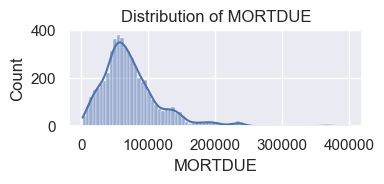

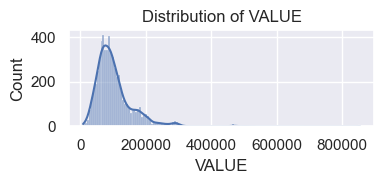

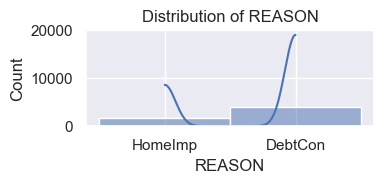

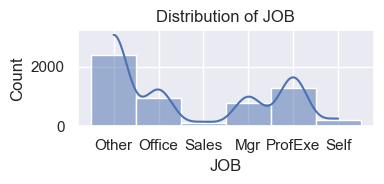

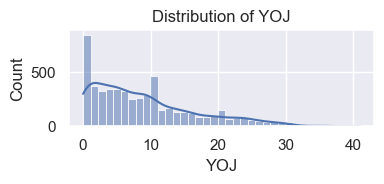

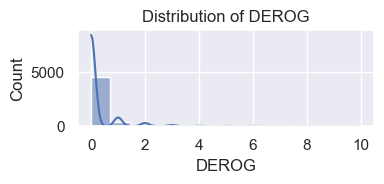

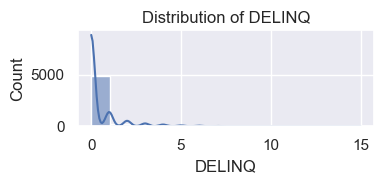

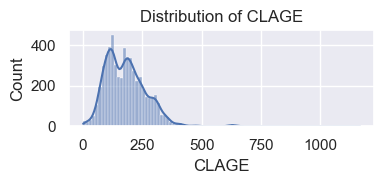

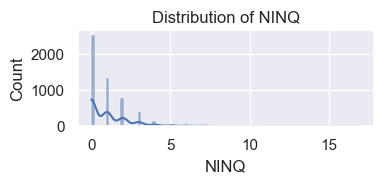

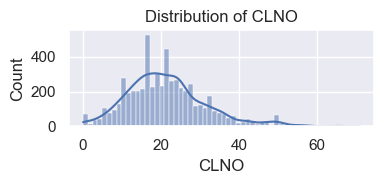

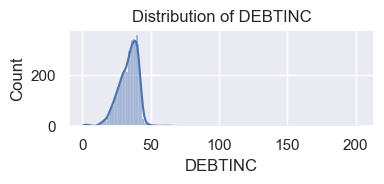

In [73]:
# Check features before imputation to see the possibilities of imputation
cols_with_na = df.columns[df.isnull().any()]

for col in cols_with_na:
  plt.figure(figsize=(4,2))
  sns.histplot(df[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.tight_layout()
  plt.show()

For ~N(M, Std) we can impute the null values with mean

For skewed distibution, long tailed we will impute median

For categorical with majority of values with mode

The rest will be dropped. This will balance the data quality and predictive performance

In [74]:
# Impute mean for DEBTINC and CLNO
df['DEBTINC'].fillna(df['DEBTINC'].mean(), inplace=True)
df['CLNO'].fillna(df['CLNO'].mean(), inplace=True)

# Impute median for MORTDUE and VALUE
df['MORTDUE'].fillna(df['MORTDUE'].median(), inplace=True)
df['VALUE'].fillna(df['VALUE'].median(), inplace=True)

# Impute mode for DEROG and DELINQ
df['DEROG'].fillna(0, inplace=True)
df['DELINQ'].fillna(0, inplace=True)

# Drop the rest null values
df.dropna(inplace=True)

# Check result
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4831 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      4831 non-null   int64  
 1   LOAN     4831 non-null   int64  
 2   MORTDUE  4831 non-null   float64
 3   VALUE    4831 non-null   float64
 4   REASON   4831 non-null   object 
 5   JOB      4831 non-null   object 
 6   YOJ      4831 non-null   float64
 7   DEROG    4831 non-null   float64
 8   DELINQ   4831 non-null   float64
 9   CLAGE    4831 non-null   float64
 10  NINQ     4831 non-null   float64
 11  CLNO     4831 non-null   float64
 12  DEBTINC  4831 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 528.4+ KB


In [75]:
# Check for duplicates
df.drop_duplicates(inplace=True)
df.shape

(4831, 13)

No duplicated data found

In [76]:
# Rename the variables for better visualization and report
df.rename(columns={
    'BAD': 'default_flag',
    'LOAN': 'loan_amount',
    'MORTDUE': 'mortgage_due',
    'VALUE': 'property_value',
    'REASON': 'loan_reason',
    'JOB': 'job_type',
    'YOJ': 'years_on_job',
    'DEROG': 'derogatory_reports',
    'DELINQ': 'delinquent_credit',
    'CLAGE': 'oldest_credit_line',
    'NINQ': 'recent_credit_inquiries',
    'CLNO': 'open_credit_lines',
    'DEBTINC': 'debt_income_ratio'
}, inplace = True)

df.head(2)

,default_flag,loan_amount,mortgage_due,property_value,loan_reason,job_type,years_on_job,derogatory_reports,delinquent_credit,oldest_credit_line,recent_credit_inquiries,open_credit_lines,debt_income_ratio
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,33.779915


### **Download CSV for TableAU Analysis**

In [77]:
#df.to_csv('credit_risk-240625_TableAU.csv', index=False)
#files.download('credit_risk-240625_TableAU.csv')

### **Treating Outliers**

In [78]:
def treat_outliers(df, col):
    '''
    treats outliers in a variable by capping them
    col: str, name of the numerical variable
    df: data frame
    col: name of the column
    '''

    q1= df[col].quantile(0.25)  
    q3= df[col].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr

    df[col] = np.clip(df[col], lower_whisker, upper_whisker)
    return df

In [79]:
def treat_outliers_all(df, col_list):
    '''
    Treat outliers in all numerical variables.
    col_list: list of numerical variables
    df: dataframe
    '''
    for c in col_list:
        df = treat_outliers(df, c)
    return df

In [80]:
df_raw = df.copy()

numerical_col = df_raw.select_dtypes(include=np.number).columns.tolist()
numerical_col.remove('default_flag')

df = treat_outliers_all(df_raw, numerical_col)

### **MODEL Building - Approach**

### **Data Preparation**

In [ ]:
# Drop dependent variable from the dataframe and create the X(independent variable) matrix
x = df.drop('default_flag', axis=1)
y = df['default_flag']

In [ ]:
# Create dummy variables for categorical variable
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
x = pd.get_dummies(x, columns= categorical_cols, drop_first=True)

In [ ]:
# train test split 70-30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.3, random_state= 22, stratify=y)

Class distribution in y: default_flag
0    3837
1     994
Name: count, dtype: int64


### **Model Evaluation Criterion**

In [126]:
#Create Metric function
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(4,2))
    sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['Non Default', 'Default'], yticklabels=['Non Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### **Build Logistic Regression Model**

In [127]:
# Fitting model on trainiong data
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2685
           1       0.33      0.00      0.01       696

    accuracy                           0.79      3381
   macro avg       0.56      0.50      0.45      3381
weighted avg       0.70      0.79      0.70      3381



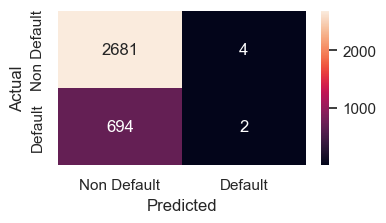

In [128]:
# Checking performance on the train dataset
logreg_train_pred = logreg.predict(x_train)
metrics_score(y_train, logreg_train_pred)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1152
           1       0.67      0.02      0.04       298

    accuracy                           0.80      1450
   macro avg       0.73      0.51      0.46      1450
weighted avg       0.77      0.80      0.71      1450



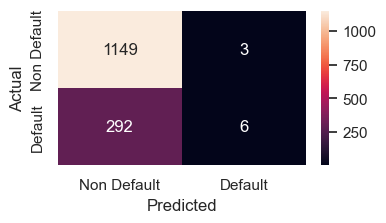

In [129]:
# Checking performance on test 
logreg_test_pred = logreg.predict(x_test)
metrics_score(y_test, logreg_test_pred)

In [103]:
# Check coefficients for beta weight
coefficients = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': logreg.coef_[0]
})

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

coefficients.drop(columns='Abs_Coefficient', inplace=True)
print(coefficients)

                    Feature  Coefficient
7   recent_credit_inquiries     0.024274
3              years_on_job    -0.022830
8         open_credit_lines     0.021858
9         debt_income_ratio     0.007894
6        oldest_credit_line    -0.006291
11          job_type_Office    -0.004233
15            job_type_Self     0.001278
13         job_type_ProfExe    -0.001269
12           job_type_Other     0.001110
14           job_type_Sales     0.000882
10      loan_reason_HomeImp     0.000127
0               loan_amount    -0.000020
1              mortgage_due    -0.000006
2            property_value    -0.000001
4        derogatory_reports     0.000000
5         delinquent_credit     0.000000


### **Tree Based Model**

In [130]:
# Defining decision tree model with class weights
dtree = DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state =22)

# Fitting the model
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=22)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2685
           1       1.00      1.00      1.00       696

    accuracy                           1.00      3381
   macro avg       1.00      1.00      1.00      3381
weighted avg       1.00      1.00      1.00      3381



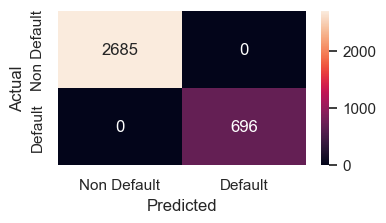

In [131]:
#checking performance on train
dtree_train_pred = dtree.predict(x_train)
metrics_score(y_train, dtree_train_pred)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1152
           1       0.68      0.58      0.62       298

    accuracy                           0.86      1450
   macro avg       0.79      0.75      0.77      1450
weighted avg       0.85      0.86      0.85      1450



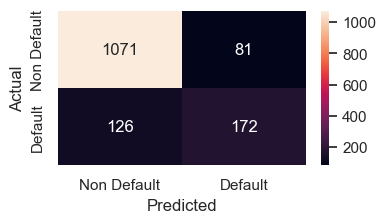

In [132]:
#checking performance on test
dtree_test_pred = dtree.predict(x_test)
metrics_score(y_test, dtree_test_pred)

### **Decision Tree Hyperparameter Tuning**

In [133]:
# Tune Decision tree hyperparameters with params
dtree_clf = DecisionTreeClassifier(random_state = 22)

param_grid = {
    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'criterion': ['gini', 'entropy']
}

scoring = 'recall'
grid_search = GridSearchCV(estimator= dtree_clf, param_grid = param_grid, scoring=scoring, cv=5)

grid_search.fit(x_train, y_train)

dtree_gs = grid_search.best_estimator_

dtree_gs.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=22)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2685
           1       0.64      0.73      0.68       696

    accuracy                           0.86      3381
   macro avg       0.79      0.81      0.80      3381
weighted avg       0.87      0.86      0.86      3381



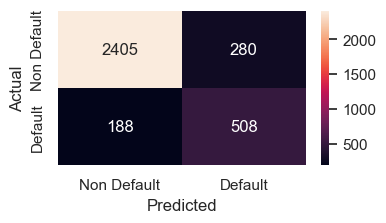

In [134]:
# Check performance on train
dtree_gs_train_pred = dtree_gs.predict(x_train)
metrics_score(y_train, dtree_gs_train_pred)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1152
           1       0.66      0.71      0.69       298

    accuracy                           0.87      1450
   macro avg       0.79      0.81      0.80      1450
weighted avg       0.87      0.87      0.87      1450



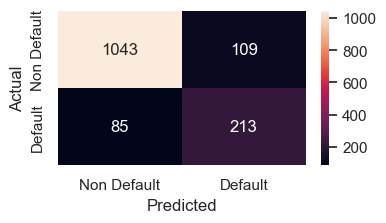

In [135]:
# Check performance on test 
dtree_gs_test_pred = dtree_gs.predict(x_test)
metrics_score(y_test, dtree_gs_test_pred)

### **Random Forest model with Class Weights**

In [136]:
# Defining random forest model with class weights
rf = RandomForestClassifier(class_weight={0:0.2,1:0.8}, random_state=22)

# Fitting random forest model
rf.fit(x_train,y_train)


RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=22)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2685
           1       1.00      1.00      1.00       696

    accuracy                           1.00      3381
   macro avg       1.00      1.00      1.00      3381
weighted avg       1.00      1.00      1.00      3381



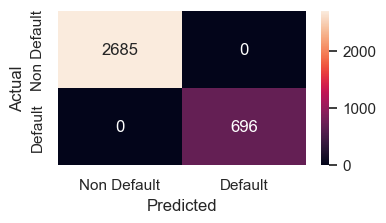

In [137]:
# Check performance on train
rf_train_pred = rf.predict(x_train)
metrics_score(y_train, rf_train_pred)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1152
           1       0.87      0.60      0.71       298

    accuracy                           0.90      1450
   macro avg       0.89      0.79      0.83      1450
weighted avg       0.90      0.90      0.89      1450



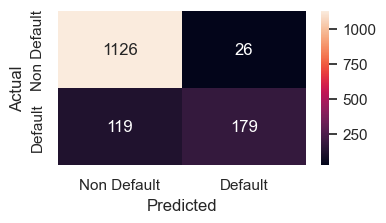

In [138]:
# Check performance on test
rf_test_pred = rf.predict(x_test)
metrics_score(y_test, rf_test_pred)

### **Random Forest Hyper Parameter Tuning**

In [139]:
# Hyperparameter tuning random forest classifier
rf_clf = RandomForestClassifier(random_state =22)

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2,5],
    'criterion': ['gini', 'entropy']
}

scoring = 'recall'

grid_search = GridSearchCV(estimator= rf_clf, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(x_train,y_train)

rf_best = grid_search.best_estimator_
rf_best.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       random_state=22)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2685
           1       1.00      0.99      1.00       696

    accuracy                           1.00      3381
   macro avg       1.00      1.00      1.00      3381
weighted avg       1.00      1.00      1.00      3381



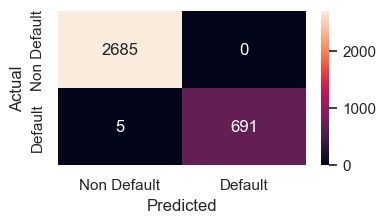

In [140]:
# Check performance on train
rf_best_train_pred = rf_best.predict(x_train)
metrics_score(y_train, rf_best_train_pred)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1152
           1       0.86      0.62      0.72       298

    accuracy                           0.90      1450
   macro avg       0.89      0.80      0.83      1450
weighted avg       0.90      0.90      0.90      1450



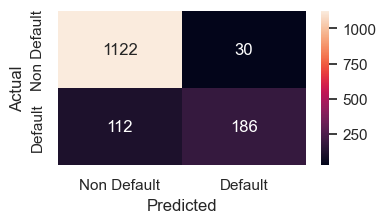

In [141]:
rf_best_test_pred = rf_best.predict(x_test)
metrics_score(y_test, rf_best_test_pred)

### **Feature importance of Random Forest Classifier**

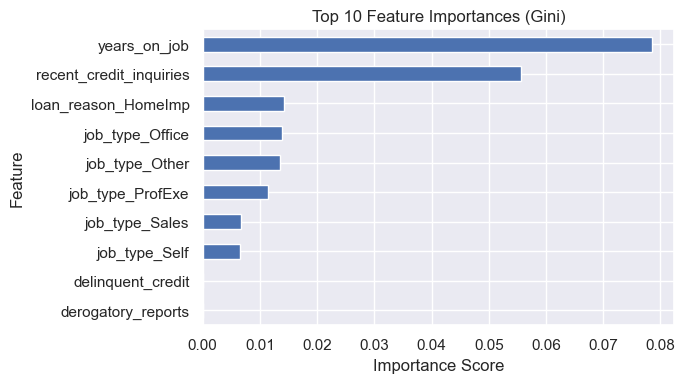

In [148]:
# Plot the Feature importance of the tuned Random Forest
feature_importance = pd.Series(rf_best.feature_importances_, index=x_train.columns)
feature_importance = feature_importance.sort_values(ascending=True)

# Visualization
plt.figure(figsize=(7,4))
feature_importance.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Gini)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### **Model Performance Comparison**

In [149]:
def get_score(type, model, flag=True, x_train=x_train, x_test=x_test):
    '''
    model: classifier to predict values of x
    type input : recall_score/precision_score/score(for accuracy)
    '''
    res = []
    if type == 'score':
        train_acc = model.score(x_train,y_train)
        test_acc = model.score(x_test,y_test)
        res.append(train_acc)
        res.append(test_acc)

        if flag == True:
            print("Accuracy Score on training set: ", model.score(x_train, y_train))
            print("Accuracy Score on testing set: ", model.score(x_test,y_test))

    elif type == 'recall_score' or type == 'accuracy_score':
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        train_recall = metrics.type(y_train,pred_train)
        test_recall = metrics.type(y_test, pred_test)
        res.append(train_recall)
        res.append(test_recall)

        if flag == True:
            print("{type} on training set: ", metrics.type(y_train,pred_train))
            print("{type} on test set: ", metrics.type(y_test,pred_test))

    else: 
        return print("type error, {type} is not recognized")
    return res